In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import keras
from skimage.transform import resize
from keras.layers import *
from keras.models import *
from keras.optimizers import *

Using TensorFlow backend.


In [2]:
train_data = pd.read_csv('../input/train.csv')

Get the unique image ids

In [3]:
unique_images = train_data.ImageId.unique()

The following function get the mask for each of the 46 category

In [4]:
def get_masks(image_id, resized_shape=(128, 128)):
  masks = dict()
  temp = train_data[train_data.ImageId == image_id]
  for i in range(temp.shape[0]):
    width = temp.iloc[i].Width
    height = temp.iloc[i].Height
    class_id = temp.iloc[i].ClassId.split()[0]
    mask_encoded = temp.iloc[i].EncodedPixels.split()
    mask = [0] * (width*height)
    for j in range(0, len(mask_encoded), 2):
      mask[int(mask_encoded[j]): int(mask_encoded[j])+int(mask_encoded[j+1])] = [1]*int(mask_encoded[j+1])
    mask = np.fliplr(np.flip(np.rot90(np.array(mask).reshape((width, height)))))
    mask = resize(mask, resized_shape, anti_aliasing=True)
    masks[int(class_id)] = mask
  masks_classes = []
  for i in range(46):
    if i in masks:
      masks_classes.append(masks[i])
    else:
      masks_classes.append(np.zeros(resized_shape))
  masks_classes = np.array(masks_classes)
  return masks_classes

In [8]:
train_data[train_data.ImageId == unique_images[1]]

,ImageId,EncodedPixels,Height,Width,ClassId
9,0000fe7c9191fba733c8a69cfaf962b7.jpg,2201176 1 2203623 3 2206071 5 2208518 8 221096...,2448,2448,33
10,0000fe7c9191fba733c8a69cfaf962b7.jpg,1343707 9 1346138 27 1348569 44 1351000 62 135...,2448,2448,1


resizing to the same size

In [9]:
masks = get_masks(unique_images[1], (2448, 2448))

/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


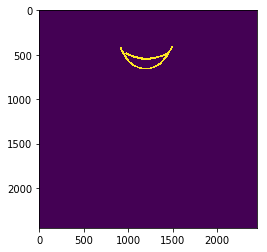

In [10]:
plt.imshow(masks[33])

resizing to the size we need for the model

In [11]:
masks = get_masks(unique_images[1], (128, 128))

/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


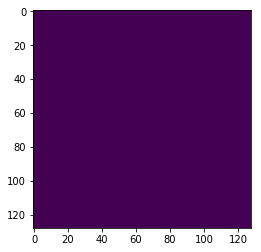

In [12]:
plt.imshow(masks[33])

Using Maxpooling for resizing not to lose the edges that are very thin

In [13]:
model_resize = Sequential()
model_resize.add(MaxPool2D((2, 2), data_format='channels_first', input_shape=(46, 1024, 1024)))
model_resize.add(MaxPool2D((2, 2), data_format='channels_first'))
model_resize.add(MaxPool2D((2, 2), data_format='channels_first'))

resizing to 1024 using usual resizing then to 128 using maxpooling

In [16]:
masks = get_masks(unique_images[1], (1024, 1024))
masks = model_resize.predict(np.array([masks]))[0]

/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


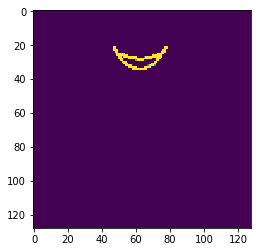

In [19]:
plt.imshow(masks[33])